In [54]:
import os
import sys
import dotenv

from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    SaveTask
)
from eolearn.io import ImportFromTiffTask
from sentinelhub import BBox

import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

In [4]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')
data_root_path

'D:/sdb_datasets'

In [44]:
bahamas_aoi_df = gpd.read_file(os.path.join(data_root_path, 'shapes', 'sbd_bahamas_aoi.shp')).to_crs('EPSG:32617')


def to_bbox(gdf):
    minx, miny, maxx, maxy = gdf.total_bounds
    bbox = BBox([minx, miny, maxx, maxy], crs=f'EPSG:{gdf.crs.to_epsg()}')
    return bbox


reference_bbox = to_bbox(bahamas_aoi_df)
reference_bbox

BBox(((761913.0990293844, 2793330.8165371595), (781392.375100563, 2807667.0494212266)), crs=CRS('32617'))

In [55]:
bathy_feature = (FeatureType.DATA_TIMELESS, 'bathy_data')
import_bahamas = ImportFromTiffTask(
    bathy_feature,
    # I'm using abspath here because some EOLearn tasks don't like mixed forward
    # and backward slashes and abspath usually cleans that up
    os.path.abspath(os.path.join(data_root_path, 'target_bahamas.tif'))
)

clip_bathy_band = eolx.raster.ClipBoxTask(bathy_feature, target_bounds=reference_bbox)

reproject_bathy = eolx.raster.ReprojectRasterTask(
    bathy_feature,
    target_resolution=(10, 10),
)

append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask(
    bathy_feature, band_index=0
)

output_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_bathy_eop')
)
save_eop = SaveTask(output_path)

output_label = 'bahamas_bathy_eop'
nodes = linearly_connect_tasks(
    import_bahamas,
    clip_bathy_band,
    reproject_bathy,
    append_bathy_data_mask,
    save_eop,
    OutputTask(output_label)
)
workflow = EOWorkflow(nodes)

workflow_result = workflow.execute()
bahamas_bathy_eop = workflow_result.outputs[output_label]

bahamas_bathy_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(1434, 1948, 1), dtype=float64)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(1434, 1948, 1), dtype=uint8)
  }
  bbox=BBox(((761913.0990293846, 2793327.049421226), (781393.0990293846, 2807667.049421226)), crs=CRS('32617'))
)

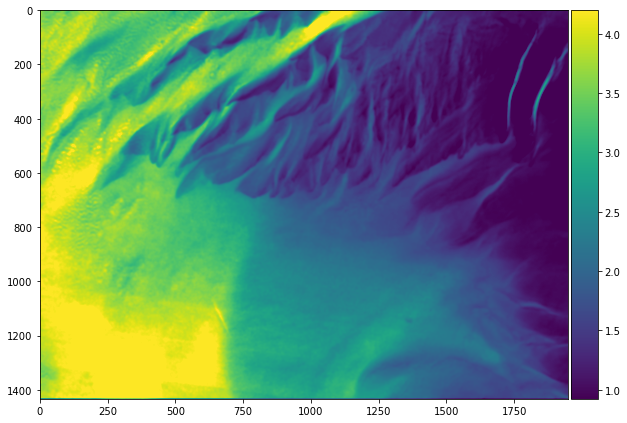

In [52]:
eolx.visualization.plot_single_band(bahamas_bathy_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')
plt.show()

In [ ]:
import_bahamas = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), os.path.join(data_root_path,'../data/mille_lacs.tiff'))
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop